In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import serial

# 시리얼 포트 설정
port = '/dev/ttyACM1'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (1초)

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            print(data, end='')  # 수신된 데이터 출력

except serial.SerialException as e:
    print(f"Error opening or using serial port: {e}")

except KeyboardInterrupt:
    print("\nExiting program.")

finally:
    if ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")

Connected to /dev/ttyACM1 at 460800 baudrate.
,       8
DIST: 2.48 m 
 97,       76,       92,       55,       54,       14,       95,       38,       23,       10,       5,        3,        21,       57,       14,       63,       3,        69,       63,       15,       30,       40,       33,       26,       44,       55,       43,       27,       72,       99,       47,       22,       87,       47,       42,       29,       27,       60,       81,       47,       24,       31,       65,       41,       22,       35,       43,       40,       34,       40,       42,       57,       70,       60,       33,       56,       14,       59,       56,       50,       64,       23,       13,       8,        60,       57,       51,       21,       16,       19,       81,       33,       25,       40,       32,       20,       39,       53,       39,       41,       33,       52,       98,       38,       35,       55,       35,       49,       38,       10,   31,   45,   57,  98,   72,   29, 

In [6]:
import serial

# 시리얼 포트 설정
port = '/dev/ttyACM1'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (1초)

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")
    data_buffer = ""  # 수신 데이터를 임시 저장할 버퍼
    temp_list = []  # 임시 리스트
    final_list = []  # 최종 리스트

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            data_buffer += data  # 수신 데이터를 버퍼에 추가

            # 버퍼 내의 데이터에서 완성된 부분을 처리
            if ',' in data_buffer:
                # 데이터를 콤마를 기준으로 분할
                split_data = data_buffer.split(',')
                # 마지막 요소는 아직 완성되지 않은 데이터일 수 있으므로 버퍼에 남김
                data_buffer = split_data[-1]
                # 완성된 데이터들만 임시 리스트에 추가
                temp_list.extend([value.strip() for value in split_data[:-1]])

                # "DIST" 문자열을 만났는지 확인
            if "D" in data_buffer:
                # "DIST" 문자열을 만나면 임시 리스트를 최종 리스트에 추가
                final_list.append(temp_list)
                # 임시 리스트 초기화
                temp_list = []


finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")

Connected to /dev/ttyACM1 at 460800 baudrate.
Serial port closed.


KeyboardInterrupt: 

In [7]:
temp_list

['\x00\x00\nDIST: 2.51 m \n\x0031',
 '\x00\x00\x00\x00\x00\x0057',
 '\x00\x00\x00\x00\x00\x0043',
 '\x00\x00\x00\x00\x00\x0060',
 '\x00\x00\x00\x00\x00\x0021',
 '\x00\x00\x00\x00\x00\x0059',
 '\x00\x00\x00\x00\x00\x0097',
 '\x00\x00\x00\x00\x00\x0066',
 '\x00\x00\x00\x00\x00\x0067',
 '\x00\x00\x00\x00\x00\x0042',
 '\x00\x00\x00\x00\x00\x0035',
 '\x00\x00\x00\x00\x00\x0022',
 '\x00\x00\x00\x00\x00\x0044',
 '\x00\x00\x00\x00\x00\x0082',
 '\x00\x00\x00\x00\x00\x00107',
 '\x00\x00\x00\x00\x0034',
 '\x00\x00\x00\x00\x00\x0061',
 '\x00\x00\x00\x00\x00\x0034',
 '\x00\x00\x00\x00\x00\x0060',
 '\x00\x00\x00\x00\x00\x0047',
 '\x00\x00\x00\x00\x00\x0048',
 '\x00\x00\x00\x00\x00\x0058',
 '\x00\x00\x00\x00\x00\x0083',
 '\x00\x00\x00\x00\x00\x0083',
 '\x00\x00\x00\x00\x00\x0083',
 '\x00\x00\x00\x00\x00\x0097',
 '\x00\x00\x00\x00\x00\x0024',
 '\x00\x00\x00\x00\x00\x0028',
 '\x00\x00\x00\x00\x00\x0064',
 '\x00\x00\x00\x00\x00\x0074',
 '\x00\x00\x00\x00\x00\x0031',
 '\x00\x00\x00\x00\x00\x00101',
 '\x0

In [26]:
import serial
import re

# 시리얼 포트 설정
port = '/dev/ttyACM1'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (2초)

def clean_data(raw_data):
    """
    수신된 원시 데이터를 정제하여 숫자 값 리스트로 반환합니다.
    """
    cleaned_data = []
    for item in raw_data:
        # 문자열 내의 숫자 패턴 찾기
        match = re.search(r'\d+\.\d+|\d+', item)
        if match:
            cleaned_data.append(float(match.group()))
    return cleaned_data

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")
    data_buffer = ""  # 수신 데이터를 임시 저장할 버퍼
    temp_list = []  # 임시 리스트
    final_list = []  # 최종 리스트

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            data_buffer += data  # 수신 데이터를 버퍼에 추가

            # 버퍼 내의 데이터에서 완성된 부분을 처리
            if ',' in data_buffer:
                # 데이터를 콤마를 기준으로 분할
                split_data = data_buffer.split(',')
                # 마지막 요소는 아직 완성되지 않은 데이터일 수 있으므로 버퍼에 남김
                data_buffer = split_data[-1]
                # 완성된 데이터들만 임시 리스트에 추가
                temp_list.extend([value.strip() for value in split_data[:-1]])

            # "DIST" 문자열을 만났는지 확인
            if "D" in data_buffer:
                # "DIST" 문자열을 만나면 임시 리스트를 최종 리스트에 추가
                cleaned_temp_list = clean_data(temp_list)  # 데이터 정제
                if len(cleaned_temp_list) % 992 == 0:
                    for i in range(0, len(cleaned_temp_list), 992):
                        final_list.append(cleaned_temp_list[i:i + 992])
                else:
                    final_list.append(cleaned_temp_list)
                print(f"Data saved: {cleaned_temp_list}")
                # 임시 리스트 초기화
                temp_list = []

finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")


Connected to /dev/ttyACM1 at 460800 baudrate.
Data saved: [2.47, 37.0, 42.0, 75.0, 60.0, 62.0, 62.0, 66.0, 22.0, 80.0, 50.0, 84.0, 67.0, 48.0, 16.0, 87.0, 101.0, 130.0, 120.0, 77.0, 64.0, 65.0, 8.0, 3.0, 12.0, 51.0, 44.0, 64.0, 80.0, 98.0, 62.0, 30.0, 74.0, 40.0, 20.0, 59.0, 84.0, 55.0, 80.0, 9.0, 79.0, 34.0, 38.0, 49.0, 74.0, 94.0, 35.0, 30.0, 49.0, 55.0, 67.0, 85.0, 61.0, 27.0, 85.0, 30.0, 71.0, 78.0, 38.0, 19.0, 49.0, 69.0, 77.0, 69.0, 65.0, 49.0, 21.0, 57.0, 42.0, 85.0, 62.0, 61.0, 52.0, 89.0, 143.0, 110.0, 66.0, 13.0, 8.0, 47.0, 84.0, 28.0, 22.0, 25.0, 59.0, 87.0, 43.0, 26.0, 47.0, 20.0, 16.0, 61.0, 87.0, 36.0, 30.0, 14.0, 51.0, 84.0, 48.0, 72.0, 37.0, 108.0, 90.0, 30.0, 49.0, 31.0, 28.0, 38.0, 89.0, 50.0, 89.0, 81.0, 68.0, 88.0, 120.0, 102.0, 69.0, 65.0, 55.0, 55.0, 73.0, 80.0, 60.0, 43.0, 43.0, 101.0, 42.0, 37.0, 42.0, 77.0, 80.0, 91.0, 72.0, 30.0, 43.0, 37.0, 58.0, 5.0, 95.0, 114.0, 58.0, 76.0, 5.0, 89.0, 53.0, 65.0, 75.0, 106.0, 118.0, 53.0, 98.0, 45.0, 103.0, 22.0, 21.0, 17.0

KeyboardInterrupt: 

In [27]:
final_list = pd.DataFrame(final_list)
final_list.shape

(13, 992)

In [31]:
distance = final_list[0]
final_list = final_list.drop(0, axis=1)
print(final_list.shape)
print(distance.shape)

(13, 991)
(13,)


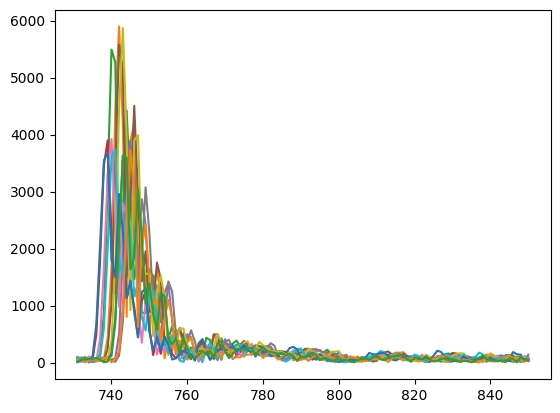

In [47]:
for i in range(13):
    final_list.loc[i][730:850].plot()
    